## more dimensions

we'll start to track what happens as we adjust parameters in our network, starting with the embedding space

start easy - bump up dimensions from two to three

this also means we can still easily visualise what's going on

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
context_length = 5

# our expanded embedding space
embedding_dimensions = 3

## Start bundling

we've just bundled our basic sampling functions into a file so we can avoid showing the same stuff over in the notebooks

In [3]:
%run ../lib/basic_sampling.py

In [4]:
names = NameSampling("../resources/names.txt")

x, y = names.get_xys(names.sample_names(2))

In [8]:
# just verify things look like we expect
x, y, len(names.itos)

([[0, 0, 0, 0, 0],
  [0, 0, 0, 0, 5],
  [0, 0, 0, 5, 22],
  [0, 0, 5, 22, 1],
  [0, 5, 22, 1, 8],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 12],
  [0, 0, 0, 12, 15],
  [0, 0, 12, 15, 18],
  [0, 12, 15, 18, 5],
  [12, 15, 18, 5, 14]],
 [5, 22, 1, 8, 0, 12, 15, 18, 5, 14, 0],
 27)

## Now run the same network

we run exactly the same network as last time, just increasing the embedding space

In [9]:
vocab_size = len(names.itos)

es = torch.randn((vocab_size, embedding_dimensions), requires_grad=True)
W1 = torch.randn((embedding_dimensions*context_length, 100), requires_grad=True)
b1 = torch.randn(100, requires_grad=True)
W2 = torch.randn((100, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

parameters = [es, W1, b1, W2, b2]

In [10]:
names_length = names.names_length
epochs = 120
batch_size = 800
learning_rate = .2
samples = 1000

In [11]:
for ep in range(epochs):
    epoch_loss = 0
    for s in range(samples):
        x, y = names.get_xys(names.sample_names(batch_size))
        X = torch.tensor(x)
        Y = torch.tensor(y)
        train = es[X.view(-1)]
        l_in = train.view(-1, embedding_dimensions * context_length)
        
        outputL1 = torch.relu(l_in @ W1 + b1)
        
        logits = outputL1 @ W2 + b2
        
        loss = F.cross_entropy(logits, Y)

        epoch_loss += loss

        for p in parameters:
            p.grad = None
        
        loss.backward()

        for p in parameters:
            p.data -= learning_rate * p.grad
        
    learning_rate *= .99

    if ep % 10 == 0:
        print(ep, learning_rate)
        print(epoch_loss/samples)

0 0.198
tensor(2.9485, grad_fn=<DivBackward0>)
10 0.17906765085174328
tensor(2.3304, grad_fn=<DivBackward0>)
20 0.16194557364425166
tensor(2.2949, grad_fn=<DivBackward0>)
30 0.14646067393087944
tensor(2.2738, grad_fn=<DivBackward0>)
40 0.13245640819679666
tensor(2.2589, grad_fn=<DivBackward0>)
50 0.1197912012932322
tensor(2.2480, grad_fn=<DivBackward0>)
60 0.10833701519337073
tensor(2.2404, grad_fn=<DivBackward0>)
70 0.097978054600841
tensor(2.2347, grad_fn=<DivBackward0>)
80 0.08860959632523453
tensor(2.2293, grad_fn=<DivBackward0>)
90 0.08013693059030814
tensor(2.2254, grad_fn=<DivBackward0>)
100 0.07247440357209944
tensor(2.2218, grad_fn=<DivBackward0>)
110 0.06554455148756082
tensor(2.2194, grad_fn=<DivBackward0>)


In [15]:
def generate_names(num_names):
    for i in range(num_names):
        out = []
        ix = [0, 0, 0, 0, 0]
        for nl in range(10):
            xenc = es[ix]

            outputL1 = torch.relu(xenc.view(-1, embedding_dimensions * context_length) @ W1 + b1)
            
            logits = outputL1 @ W2 + b2
            
            p = F.softmax(logits, dim=1)
    
            prediction = torch.multinomial(p, num_samples=1).item()
            
            ix = [ix[1], ix[2], ix[3], ix[4], prediction]

            if prediction == 0:
                break
            out.append(names.itos[prediction])
            
        print("".join(out))

generate_names(1)

alla


In [19]:
generate_names(10)

malayah
lahonn
teazna
efhavhah
afiris
trirt
mathernann
lenea
shastoi
jaygha


In [20]:
import matplotlib.pyplot as plt

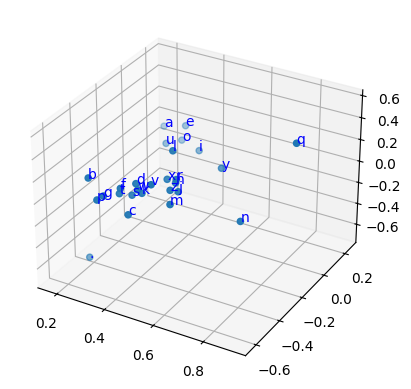

In [23]:
x = es.T[0].tolist()
y = es.T[1].tolist()
z = es.T[2].tolist()
n = ['.'] + names.letters

fig = plt.figure()
ax = plt.axes(projection='3d')

# ax.view_init(elev, azim)
# ax.set_box_aspect((1, 1, 1), zoom=zoom)

ax.scatter(x, y, z)

for i, txt in enumerate(n):
    # ax.annotate(txt, (x[i], y[i], z[i]))
    ax.text(x[i], y[i], z[i], txt, color='blue')

## OK better but...

we've decreased our loss, we're still getting nice vowels (and y) separation in the plot but things could be better

maybe we had a bad initialization this time?

next time we'll fix that and start tracking things properly